<a href="https://colab.research.google.com/github/RavinduPabasara/Iris-classification/blob/main/Iris_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Approach

Iris versicolor

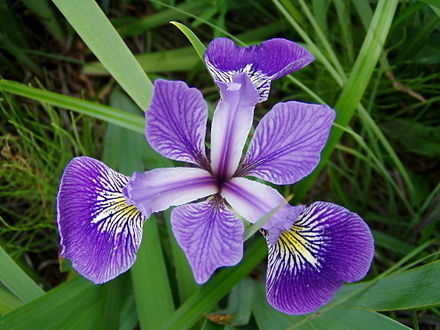

iris setosa

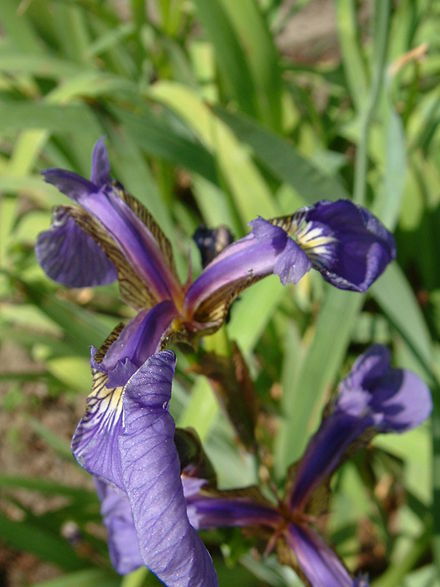

Iris verginicia

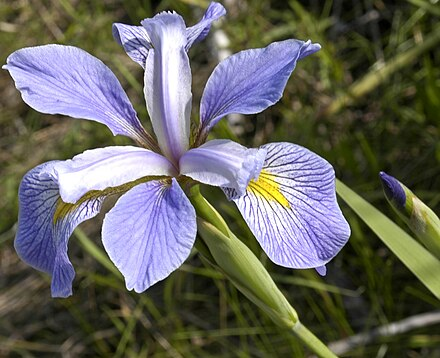

In [ ]:
!pip install seaborn

In [ ]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import joblib

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
# Data Loading and Initial Exploration
def load_and_explore_data():
    """
    Load the Iris dataset and perform comprehensive initial exploration
    Returns DataFrame and original iris object
    """
    iris = load_iris()
    df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                     columns=iris['feature_names'] + ['target'])

    # Convert target numbers to actual species names for better interpretability
    df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

    # Display comprehensive dataset information
    print("=== Dataset Information ===")
    print(f"\nTotal samples: {len(df)}")
    print(f"Features: {', '.join(iris.feature_names)}")
    print("\nClass distribution:")
    species_dist = df['species'].value_counts()
    print(species_dist)

    return df, iris

In [ ]:
df, iris = load_and_explore_data()

=== Dataset Information ===

Total samples: 150
Features: sepal length (cm), sepal width (cm), petal length (cm), petal width (cm)

Class distribution:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


In [ ]:
#  Comprehensive Correlation Analysis
def analyze_correlations(df):
    """
    Perform detailed correlation analysis with focused visualizations
    """
    # Calculate correlations
    feature_cols = [col for col in df.columns if 'target' not in col and 'species' not in col]
    correlations = df[feature_cols + ['target']].corr()

    # Create and save detailed correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlations, annot=True, cmap='RdBu', center=0, fmt='.2f')
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.savefig('correlation_heatmap_detailed.png')
    plt.show()

      # Print correlation insights
    print("\n=== Correlation Analysis ===")
    print("\nFeature correlations with target:")
    target_correlations = correlations['target'].sort_values(ascending=False)
    print(target_correlations)

    return correlations

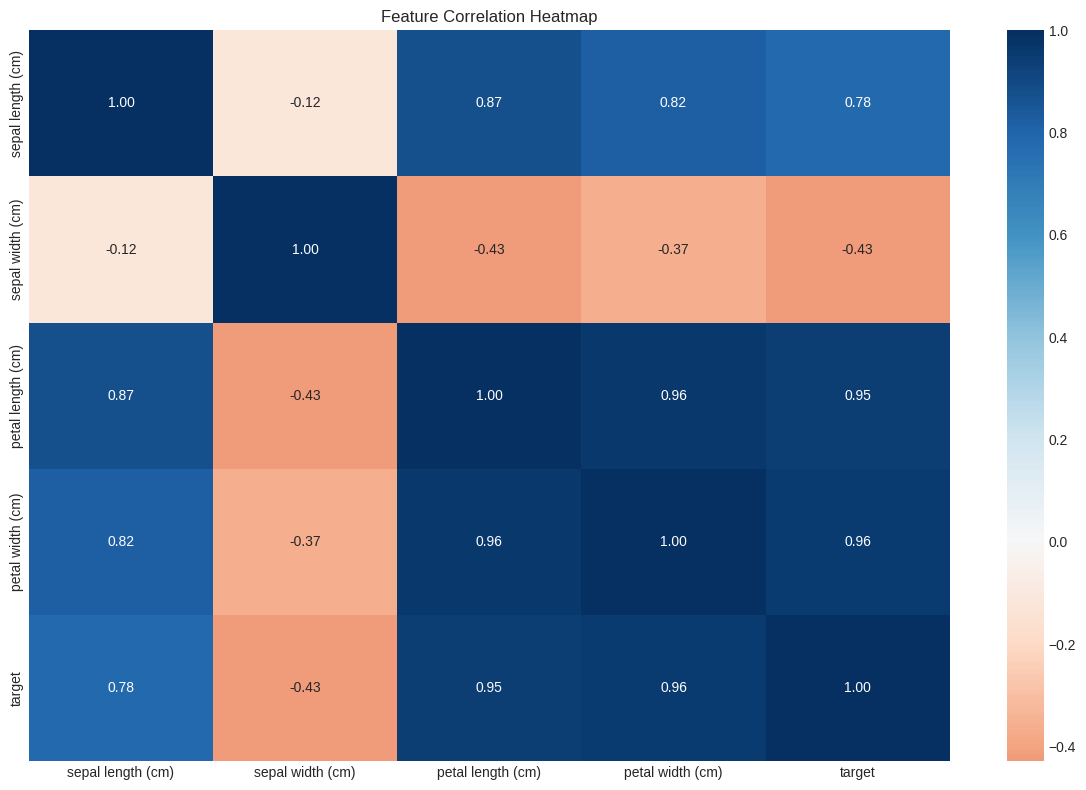


=== Correlation Analysis ===

Feature correlations with target:
target               1.000000
petal width (cm)     0.956547
petal length (cm)    0.949035
sepal length (cm)    0.782561
sepal width (cm)    -0.426658
Name: target, dtype: float64


In [ ]:
correlations = analyze_correlations(df)

In [ ]:
def further_analyze_correlations(df):

    # Create focused visualizations based on correlation strength
    plt.figure(figsize=(15, 5))

    # Strong correlation: Petal Length vs Petal Width
    plt.subplot(1, 3, 1)
    sns.scatterplot(data=df, x='petal length (cm)', y='petal width (cm)',
                    hue='species', palette='deep')
    plt.title('Strong Correlation\nPetal Length vs Width')

    # Moderate correlation: Sepal Length vs Petal Length
    plt.subplot(1, 3, 2)
    sns.scatterplot(data=df, x='sepal length (cm)', y='petal length (cm)',
                    hue='species', palette='deep')
    plt.title('Moderate Correlation\nSepal Length vs Petal Length')

    # Weak correlation: Sepal Width vs Petal Length
    plt.subplot(1, 3, 3)
    sns.scatterplot(data=df, x='sepal width (cm)', y='petal length (cm)',
                    hue='species', palette='deep')
    plt.title('Weak Correlation\nSepal Width vs Petal Length')

    plt.tight_layout()
    plt.savefig('feature_relationships.png')
    plt.show()

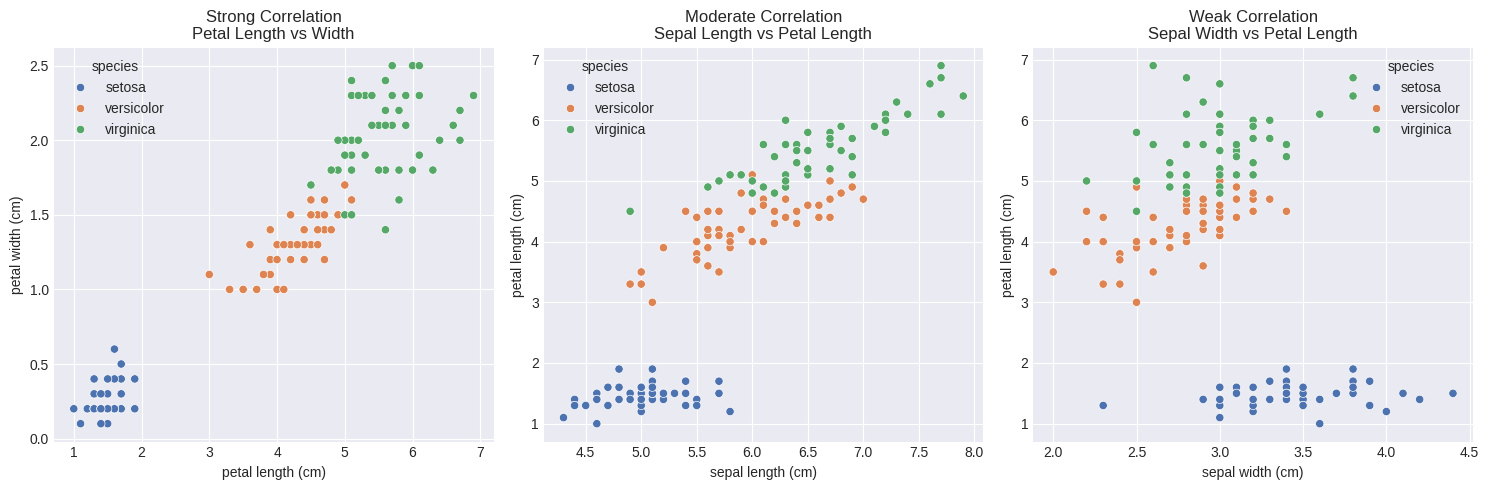

In [ ]:
further_analyze_correlations(df)

In [ ]:
#  Distribution Analysis
def analyze_distributions(df):
    """
    Analyze feature distributions across species
    """
    # Create distribution plot for each feature by species
    plt.figure(figsize=(15, 10))
    for idx, feature in enumerate([col for col in df.columns if '(cm)' in col], 1):
        plt.subplot(2, 2, idx)
        for species in df['species'].unique():
            sns.kdeplot(data=df[df['species'] == species][feature], label=species)
        plt.title(f'Distribution of {feature} by Species')
        plt.xlabel(feature)
        plt.legend()
    plt.tight_layout()
    plt.show()

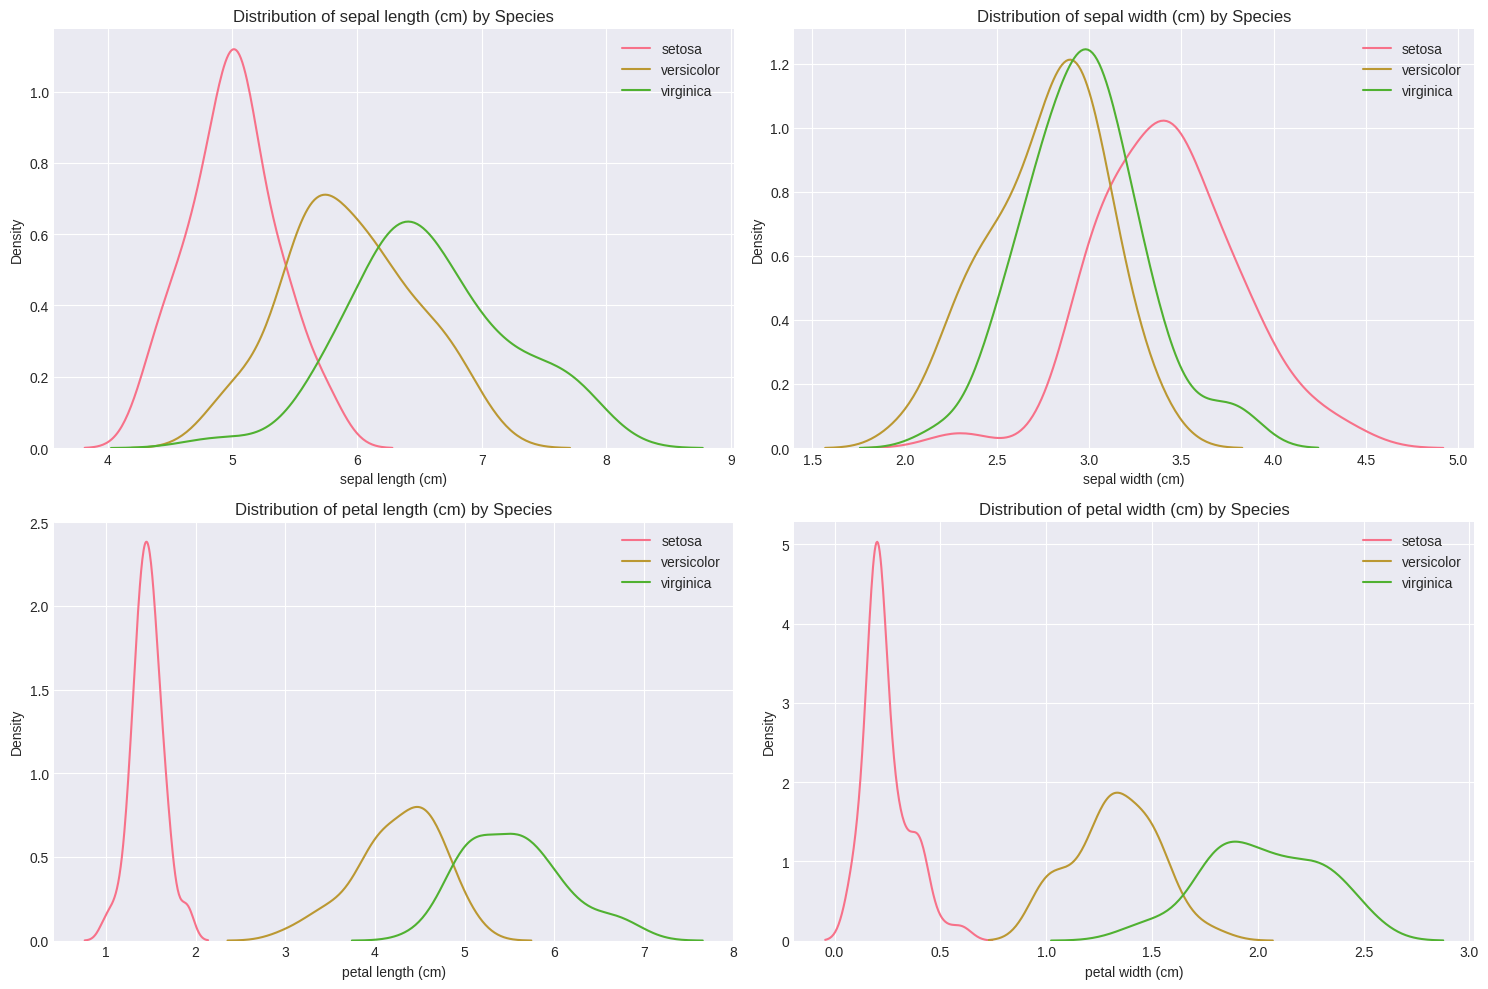

In [ ]:
analyze_distributions(df)

In [ ]:
def preprocess_data(df, correlations):
    """
    Preprocess data with correlation-informed feature handling
    """
    # Separate features and target
    X = df.drop(['target', 'species'], axis=1)
    y = df['target']

    # Analyze multicollinearity
    feature_correlations = correlations.drop('target').drop('target', axis=1)
    high_correlation_pairs = []
    for i in range(len(feature_correlations.columns)):
        for j in range(i+1, len(feature_correlations.columns)):
            if abs(feature_correlations.iloc[i, j]) > 0.8:
                high_correlation_pairs.append(
                    (feature_correlations.columns[i],
                     feature_correlations.columns[j],
                     feature_correlations.iloc[i, j])
                )

    print("\n=== Multicollinearity Analysis ===")
    print("Highly correlated feature pairs (|correlation| > 0.8):")
    for pair in high_correlation_pairs:
        print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

    # Feature importance based on correlation with target
    target_correlations = abs(correlations['target']).sort_values(ascending=False)
    print("\n=== Feature Importance from Target Correlations ===")
    print(target_correlations)

    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to DataFrame to maintain feature names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [ ]:
X_train, X_test, y_train, y_test, scaler = preprocess_data(df, correlations)


=== Multicollinearity Analysis ===
Highly correlated feature pairs (|correlation| > 0.8):
sepal length (cm) - petal length (cm): 0.872
sepal length (cm) - petal width (cm): 0.818
petal length (cm) - petal width (cm): 0.963

=== Feature Importance from Target Correlations ===
target               1.000000
petal width (cm)     0.956547
petal length (cm)    0.949035
sepal length (cm)    0.782561
sepal width (cm)     0.426658
Name: target, dtype: float64


In [ ]:
# Model Training with Cross-Validation
def train_model(X_train, X_test, y_train, y_test, iris, correlations):
    """
    Train model with correlation-informed hyperparameters
    """
    # Adjust max_features based on correlation analysis
    n_highly_correlated = sum(1 for x in correlations['target'] if abs(x) > 0.8)

    rf_model = RandomForestClassifier(
        n_estimators=100,
        # Reduce max_depth due to high feature correlations
        max_depth=4,
        # Increase min_samples_split to prevent overfitting on correlated features
        min_samples_split=8,
        # Use sqrt of number of highly correlated features
        max_features='sqrt',
        random_state=42
    )

    # Perform cross-validation
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
    print("\n=== Cross-Validation Results ===")
    print(f"CV Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Train final model
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    # Compare feature importance with correlations
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_,
        'correlation': [abs(correlations['target'][col]) for col in X_train.columns]
    }).sort_values('importance', ascending=False)

    # Visualize feature importance vs correlation
    plt.figure(figsize=(10, 6))
    x = range(len(feature_importance))
    plt.bar(x, feature_importance['importance'], alpha=0.5, label='RF Importance')
    plt.plot(x, feature_importance['correlation'], 'ro-', label='|Correlation|')
    plt.xticks(x, feature_importance['feature'], rotation=45)
    plt.title('Feature Importance vs Target Correlation')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print comparison
    print("\n=== Feature Importance vs Correlation Analysis ===")
    print(feature_importance)

    return rf_model


=== Cross-Validation Results ===
CV Scores: [0.95833333 0.95833333 0.95833333 0.95833333 0.95833333]
Mean CV Score: 0.9583 (+/- 0.0000)


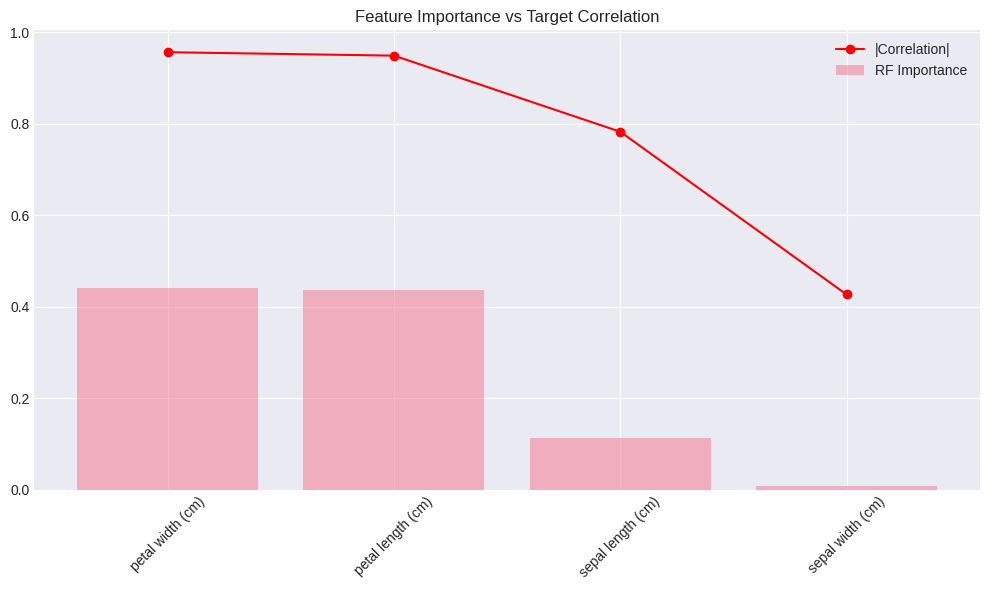


=== Feature Importance vs Correlation Analysis ===
             feature  importance  correlation
3   petal width (cm)    0.440667     0.956547
2  petal length (cm)    0.437480     0.949035
0  sepal length (cm)    0.113726     0.782561
1   sepal width (cm)    0.008127     0.426658


In [ ]:
model = train_model(X_train, X_test, y_train, y_test, iris, correlations)

In [ ]:
# Model Persistence with Validation
def save_and_validate_model(model, X_test, iris, scaler):
    """
    Save model and perform final validation
    """
    model_data = {
        'model': model,
        'scaler': scaler,
        'feature_names': iris.feature_names,
        'target_names': iris.target_names
    }

    joblib.dump(model_data, 'iris_model_complete.joblib')

    # Validate saved model
    loaded_data = joblib.load('iris_model_complete.joblib')
    loaded_model = loaded_data['model']

    # Compare predictions
    original_pred = model.predict(X_test)
    loaded_pred = loaded_model.predict(X_test)

    print("\n=== Model Persistence Validation ===")
    print("Original vs Loaded Model Predictions Match:",
          np.array_equal(original_pred, loaded_pred))

In [ ]:
save_and_validate_model(model, X_test, iris, scaler)


=== Model Persistence Validation ===
Original vs Loaded Model Predictions Match: True


In [ ]:
# the complete pipeline
# if __name__ == "__main__":
#     df, iris = load_and_explore_data()
#     correlations = analyze_correlations(df)
#     analyze_distributions(df)
#     X_train, X_test, y_train, y_test, scaler = preprocess_data(df, correlations)
#     model = train_model(X_train, X_test, y_train, y_test, iris)
#     save_and_validate_model(model, X_test, iris, scaler)

In [ ]:
def load_iris_model(model_path='iris_model_complete.joblib'):
   loaded_data = joblib.load(model_path)
   return loaded_data['model'], loaded_data['scaler'], loaded_data['target_names']

model, scaler, target_names = load_iris_model()

In [ ]:
test_cases = pd.DataFrame([
    [5.1, 3.5, 1.4, 0.2],  # Setosa
    [6.7, 3.0, 5.2, 2.3],  # Virginica
    [5.7, 2.8, 4.1, 1.3]   # Versicolor
], columns=['sepal length (cm)', 'sepal width (cm)',
           'petal length (cm)', 'petal width (cm)'])

# Correct definition of target names
target_names = ["Setosa", "Versicolor", "Virginica"]

# Transform test cases
test_cases_np = test_cases.values  # Drop feature names
scaled_input = scaler.transform(test_cases_np)

# Get predictions and probabilities
predictions = model.predict(scaled_input)
probabilities = model.predict_proba(scaled_input)

# Print results
for i, (features, pred, probs) in enumerate(zip(test_cases.values, predictions, probabilities)):
    print(f"\nSample {i+1}:")
    print(f"Features: {features}")
    try:
        print(f"Predicted: {target_names[int(pred)]}")  # Cast pred to int
    except (IndexError, ValueError):
        print("Error: Invalid prediction index or type!")
    print("Probabilities:")
    for species, prob in zip(target_names, probs):
        print(f"  {species}: {prob:.3f}")



Sample 1:
Features: [5.1 3.5 1.4 0.2]
Predicted: Setosa
Probabilities:
  Setosa: 1.000
  Versicolor: 0.000
  Virginica: 0.000

Sample 2:
Features: [6.7 3.  5.2 2.3]
Predicted: Virginica
Probabilities:
  Setosa: 0.000
  Versicolor: 0.005
  Virginica: 0.995

Sample 3:
Features: [5.7 2.8 4.1 1.3]
Predicted: Versicolor
Probabilities:
  Setosa: 0.000
  Versicolor: 0.998
  Virginica: 0.002


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


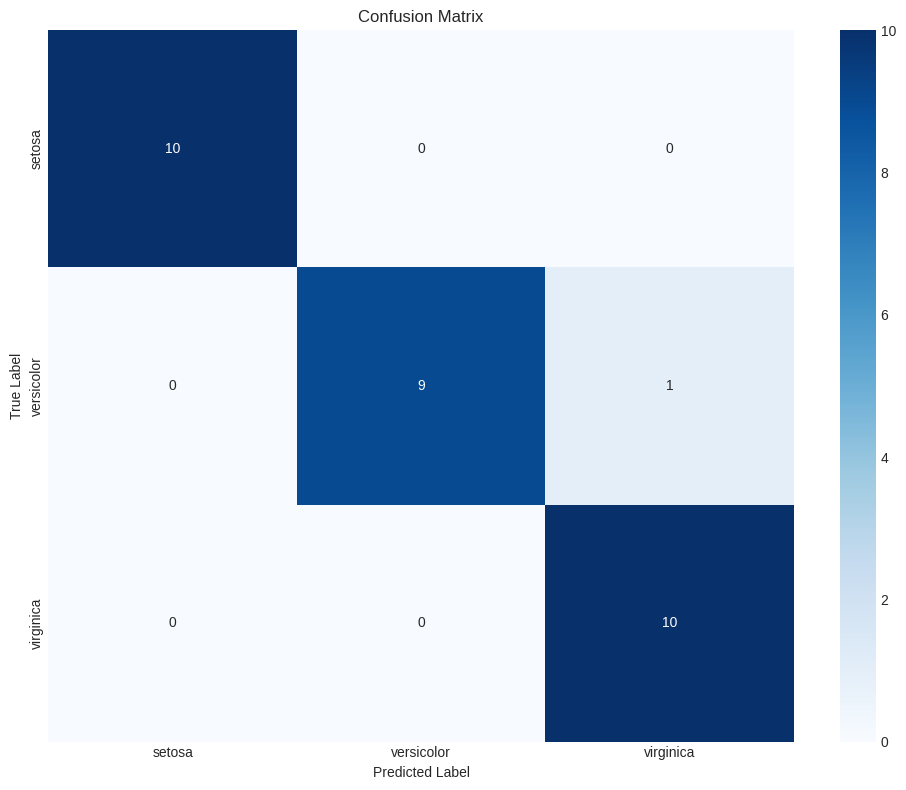


Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions
y_pred = model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create beautiful visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))